<a href="https://colab.research.google.com/github/HWMV/AIFFEL_Quest1/blob/master/Main_quest/Main_quest3/rock_scissor_paper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Main_quest3
# rock_scissor_paper
# 온라인 6기 코어 최현우

* **루브릭**
1. 이미지 분류기 모델이 성공적으로 만들어졌는가?	학습과정이 정상적으로 수행되었으며, 학습 결과에 대한 그래프를 시각화(ex. train acc / train loss / val acc / val loss 등) 해 보았음
2. 오버피팅을 극복하기 위한 적절한 시도가 있었는가?	오버피팅 극복을 위하여 데이터셋의 다양성, 정규화 등을 2가지 이상 시도해보았음
3. 분류모델의 test accuracy가 기준 이상 높게 나왔는가?	85% 이상 도달하였음

In [46]:
# 라이브러리 호출
import tensorflow as tf
import numpy as np

print(tf.__version__)
print(np.__version__)

2.14.0
1.23.5


In [47]:
# 데이터 불러오기 (로컬, 구글드라이브 마운트)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [48]:
from PIL import Image
import glob
import os

In [49]:
# 데이터 불러오기2
BASE_PATH = "/content/drive/MyDrive/Main_quest3/"

In [50]:
# paper 이미지 resize 하기 (28x28)
def resize_images(img_path):
    images=glob.glob(img_path + "/*.jpg")

    print(len(images), " images to be resized.")

    # 28 x 28 size 로 resize
    target_size=(28,28)
    for img in images:
        old_img=Image.open(img)
        new_img=old_img.resize(target_size,Image.ANTIALIAS)
        new_img.save(img, "JPEG")

    print(len(images), " images resized.")

# 함수 이용해서 가위바위보 이미지 전부 resize
resize_images(BASE_PATH + "rock")
resize_images(BASE_PATH + "scissor")
resize_images(BASE_PATH + "paper")

print("resize 완료!")

1247  images to be resized.


<ipython-input-50-5a0fe5e6b29e>:11: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  new_img=old_img.resize(target_size,Image.ANTIALIAS)


1247  images resized.
1320  images to be resized.
1320  images resized.
1284  images to be resized.
1284  images resized.
resize 완료!


In [51]:
# load_data 함수 만들기 (노드 참조)

def load_data(img_path, number_of_data=3851):
    img_size=28
    color=3
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img
        labels[idx]=0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img
        labels[idx]=1
        idx=idx+1

    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img
        labels[idx]=2
        idx=idx+1

    print("Number of images:", idx)
    return imgs, labels

In [52]:
# test_load_data 함수
def test_load_data(img_path, number_of_data=441):
    img_size=28
    color=3
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'test/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img
        labels[idx]=0
        idx=idx+1

    for file in glob.iglob(img_path+'test/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img
        labels[idx]=1
        idx=idx+1

    for file in glob.iglob(img_path+'test/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img
        labels[idx]=2
        idx=idx+1

    print("Number of images:", idx)
    return imgs, labels

In [53]:
# train_test_split 함수 불러오기
from sklearn.model_selection import train_test_split

# train data 설정
(x_data, y_data) = load_data(BASE_PATH)

# Train, Validation 데이터 분리
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2, random_state=2023)

# 데이터 정규화
x_train_norm = x_train / 255.0
x_val_norm = x_val / 255.0

print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))
print("x_val shape: {}".format(x_val.shape))
print("y_val shape: {}".format(y_val.shape))

Number of images: 3851
x_train shape: (3080, 28, 28, 3)
y_train shape: (3080,)
x_val shape: (771, 28, 28, 3)
y_val shape: (771,)


In [54]:
# Load test data
# 위 과정 경로만 바꿔서 test data 세팅
resize_images(BASE_PATH + "test/rock")
resize_images(BASE_PATH + "test/scissor")
resize_images(BASE_PATH + "test/paper")
(x_test, y_test) = test_load_data(BASE_PATH)
x_test_norm = x_test / 255.0

print("x_test shape: {}".format(x_test.shape))
print("y_test shape: {}".format(y_test.shape))

156  images to be resized.


<ipython-input-50-5a0fe5e6b29e>:11: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  new_img=old_img.resize(target_size,Image.ANTIALIAS)


156  images resized.
106  images to be resized.
106  images resized.
179  images to be resized.
179  images resized.
Number of images: 441
x_test shape: (441, 28, 28, 3)
y_test shape: (441,)


라벨:  0


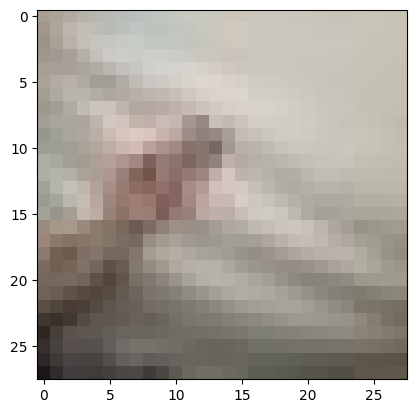

In [55]:
# 데이터들 확인
import matplotlib.pyplot as plt

plt.imshow(x_train[2])
print('라벨: ', y_train[2]) # 가위, 실제값 가위

In [56]:
# 모델 구성하기 Sequestial 모델 사용
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 데이터 증강(ImageDataGenerator() 활용)
datagen = ImageDataGenerator(
    rotation_range=10, # 이미지를 0~10도 사이로 랜덤하게 회전
    zoom_range=0.1, # 0.9~1.1 사이로 랜덤하게 확대/축소
    width_shift_range=0.1,  # 10% 범위에서 좌/우 이동
    height_shift_range=0.1, # 10% 범위에서 상/하 이동
    horizontal_flip=True # 좌우 반전
)
# train data가 너무 오버피팅(과적합) 되어서 처리 해줌
datagen.fit(x_train_norm)

# Model(Sequential) 구성 (뉴런 수 조절 : 오버피팅 방지)
model = Sequential()
# Layer 마다 뉴런 수 감소 : 오버피팅 방지
model.add(tf.keras.layers.Conv2D(128, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(tf.keras.layers.MaxPooling2D(2,2))
model.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2,2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(32, activation='relu'))

# 출력층
model.add(tf.keras.layers.Dense(3, activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 26, 26, 128)       3584      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 13, 13, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 11, 11, 64)        73792     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 1600)              0         
                                                                 
 dense_6 (Dense)             (None, 32)               

In [57]:
# 모델 compile 하기
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Early stopping 추가
early_stopping = EarlyStopping(monitor='val_loss', patience=7)

# 학습 및 검증 실행
history = model.fit(datagen.flow(x_train_norm, y_train),
                    epochs=20,
                    validation_data=(x_val_norm, y_val),
                    callbacks=[early_stopping])

Epoch 1/20
97/97 [==============================] - 12s 113ms/step - loss: 1.1014 - accuracy: 0.3562 - val_loss: 1.0926 - val_accuracy: 0.3411
Epoch 2/20
97/97 [==============================] - 9s 88ms/step - loss: 1.0545 - accuracy: 0.4399 - val_loss: 0.9341 - val_accuracy: 0.5564
Epoch 3/20
97/97 [==============================] - 10s 101ms/step - loss: 0.9416 - accuracy: 0.5481 - val_loss: 0.8697 - val_accuracy: 0.5551
Epoch 4/20
97/97 [==============================] - 11s 108ms/step - loss: 0.8645 - accuracy: 0.5974 - val_loss: 0.7318 - val_accuracy: 0.6952
Epoch 5/20
97/97 [==============================] - 9s 92ms/step - loss: 0.8140 - accuracy: 0.6399 - val_loss: 0.6802 - val_accuracy: 0.7095
Epoch 6/20
97/97 [==============================] - 9s 93ms/step - loss: 0.7335 - accuracy: 0.6834 - val_loss: 0.5668 - val_accuracy: 0.7665
Epoch 7/20
97/97 [==============================] - 10s 108ms/step - loss: 0.7117 - accuracy: 0.6958 - val_loss: 0.5207 - val_accuracy: 0.7938
Epoch

In [58]:
# Model evaluation(Train)
train_loss, train_accuracy = model.evaluate(x_train_norm, y_train, verbose=2)
print("train_loss: {} ".format(train_loss))
print("train_accuracy: {}".format(train_accuracy))

# Model evaluation(Validation)
val_loss, val_accuracy = model.evaluate(x_val_norm, y_val, verbose=2)
print("val_loss: {} ".format(val_loss))
print("val_accuracy: {}".format(val_accuracy))

# Model evaluation(Test)
test_loss, test_accuracy = model.evaluate(x_test_norm, y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

97/97 - 2s - loss: 0.2496 - accuracy: 0.9185 - 2s/epoch - 21ms/step
train_loss: 0.24961058795452118 
train_accuracy: 0.9185065031051636
25/25 - 1s - loss: 0.3053 - accuracy: 0.9027 - 834ms/epoch - 33ms/step
val_loss: 0.30527016520500183 
val_accuracy: 0.9027237296104431
14/14 - 0s - loss: 3.2473 - accuracy: 0.4943 - 431ms/epoch - 31ms/step
test_loss: 3.247300386428833 
test_accuracy: 0.4943310618400574


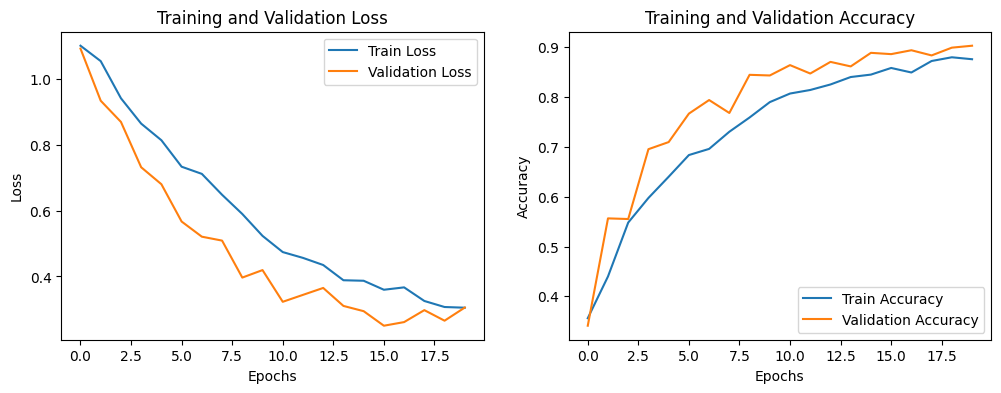

In [59]:
# 시각화
import matplotlib.pyplot as plt

# Train and Validation Loss 그래프
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Train and Validation Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

1/1 [==============================] - 0s 33ms/step


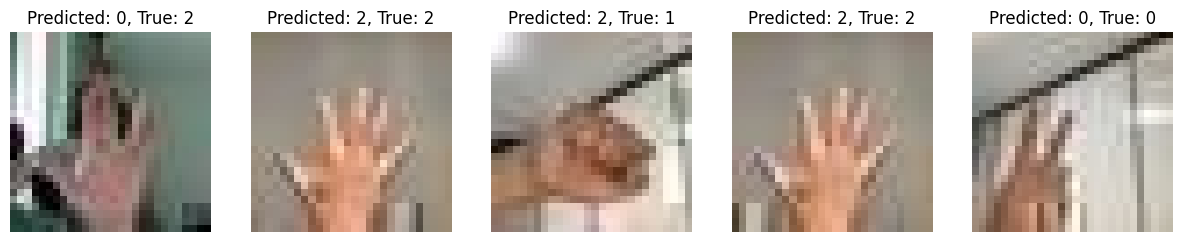

In [62]:
import random

# 테스트 데이터에서 무작위로 5개의 인덱스를 선택
random_indices = random.sample(range(x_test.shape[0]), 5)

# 해당 인덱스의 이미지와 라벨 가져오기
random_images = x_test[random_indices]
random_labels = y_test[random_indices]

# 이미지에 대한 예측값 계산
predictions = model.predict(random_images)

# 예측값에서 가장 높은 확률을 가진 클래스 선택
predicted_labels = np.argmax(predictions, axis=1)

# 이미지와 예측값, 실제값 비교하기
plt.figure(figsize=(15, 5))
for i, index in enumerate(random_indices):
    plt.subplot(1, 5, i + 1)
    plt.imshow(random_images[i])
    plt.title(f"Predicted: {predicted_labels[i]}, True: {random_labels[i]}")
    plt.axis('off')
plt.show()

# **회 고 록**
* ## train data의 오버피팅(과적합) 방지를 위한 방법
1. 데이터 shuffle 사용해보자 : 데이터 확장, 오버피팅 방지
shuffle_data = np.arange(x_train.shape[0])
np.random.shuffle(shuffle_data)

2. 데이터 증강(ImageDataGenerator(), fit에서 datagen.flow 활용)
했었으나 데이터 수를 늘리고 증강을 빼고 성능이 좋아서 삭제 했습니다 (충분히 train data로 학습)
데이터 수 회전,확대/축소 등으로 데이터 증강
(train data : 300장 > 1200장 > 3851장)
(validation data : train data 20%)
(test data : 639장)

3. 픽셀 정규화
x_data_norm = x_data / 255.0
x_train_norm = x_train / 255.0
x_val_norm = x_val / 255.0
x_test_norm = x_test / 255.0

4. dropout, BatchNormalization
각 layer 사이에 dropout(50%), BatchNormalization 적용
(train data가 너무 오버피팅 되서 조절)

---
* ## test data의 성능 향상을 위한 방법
1. epoch 수 증가 (10 > 30)
2. 데이터 셔플 제외 라벨 데이트까지 섞여서 확인 시 클래스가 섞여 나오는 것 확인
3. 쓸데없이 오버피팅 방지한 것들 제거 중 (dropout, batch normalization 등)
4. test data 비율 10~20% 정도로 줄여서 test


---

## **배우고 느낀 점**

test data를 더 늘리고, train data도 더 늘려서 작업해보고 싶지만 업로드와 epoch의 시간소요에 여기까지만 조절 했습니다

fit 학습을 여러번 반복하면 기존 학습에 이어서 학습을 해서 제대로 학습이 안되는 부분도 배웠습니다. 코드를 중복되지 않게 구현 하는 연습도 해봐야 할 것 같다고 생각 했습니다.

여러가지로 오버피팅 방지가 어렵고 관건이라고 배웠습니다. 그래도 실험해보면서 바뀌는 모습을 보면서 재밌게 작업했습니다. 여러 시도를 해보기 위해 컴퓨터 사양을 늘려야 효율적일 것 같다고 느꼈습니다.

오버피팅의 어려움을 체감하고 오버피팅(과적합) 방지에 여러 방법이 있고, 왜 사용하는지를 정확하게 이해하고 사용해야 된다는 것을 배웠습니다. 시각화의 중요성도 많이 배웠습니다.
더욱 정진 하겠습니다.

---

## **해결 못한 점**
1. pred값과 실제값 비교에서 흑백 사진의 정체
(해결 : train, test 데이터 load 하는 함수 따로 생성하고 데이터 수를 맞춰 줬습니다)
2. test 성능 향상을 마저 못했습니다
(가위 클래스 0은 잘 분석하나, 정면 바위 사진을 2(보)로 예측하는 경우가 많았습니다)
(학습 데이터에서 바위와 보 데이터를 더 확보해야 될 걳 같다고 분석했습니다)